In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
jan_data = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet', engine='pyarrow')
len(jan_data)

1154112

In [3]:
jan_data.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013


In [4]:
jan_data['duration'] = (jan_data['dropOff_datetime'] - jan_data['pickup_datetime']).dt.total_seconds()/60

In [5]:
jan_data.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.0
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.0
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.0


In [6]:
jan_data.duration.mean()

19.1672240937939

In [7]:
jan_data = jan_data[~((jan_data.duration > 100) | (jan_data.duration < 1))]

The features we'll user for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1"

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

    53%
    63%
    73%
    83%


In [8]:
jan_data.PUlocationID.isna().astype(float).mean()

0.8337791830946517

In [9]:
jan_data.PUlocationID.fillna(value=-1, inplace=True)
jan_data.DOlocationID.fillna(value=-1, inplace=True)
jan_data.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333


Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

    Turn the dataframe into a list of dictionaries
    Fit a dictionary vectorizer
    Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns)

    2
    152
    352
    525
    725


In [10]:
features = ['PUlocationID', 'DOlocationID']

In [11]:
jan_data.PUlocationID = jan_data.PUlocationID.astype(str)
jan_data.DOlocationID = jan_data.DOlocationID.astype(str)

In [12]:
jan_dicts = jan_data[features].to_dict(orient='records')

In [13]:
jan_dicts[0]

{'PUlocationID': '-1.0', 'DOlocationID': '-1.0'}

In [14]:
dv = DictVectorizer()

In [15]:
vectorized_data = dv.fit_transform(jan_dicts, jan_data.duration)

In [16]:
vectorized_data.shape

(1129678, 525)

In [17]:
dv.feature_names_[:3]

['DOlocationID=-1.0', 'DOlocationID=1.0', 'DOlocationID=10.0']

Now let's use the feature matrix from the previous step to train a model.

    Train a plain linear regression model with default parameters
    Calculate the RMSE of the model on the training data

What's the RMSE on train?

    5.52
    10.52
    15.52
    20.52


In [31]:
lr = LinearRegression()

In [32]:
lr.fit(vectorized_data, jan_data.duration)

LinearRegression()

In [33]:
jan_data.duration.describe(percentiles=[0.9999])

count     1.129678e+06
mean      1.726004e+01
std       1.380091e+01
min       1.000000e+00
50%       1.348333e+01
99.99%    9.960000e+01
max       1.000000e+02
Name: duration, dtype: float64

<AxesSubplot:>

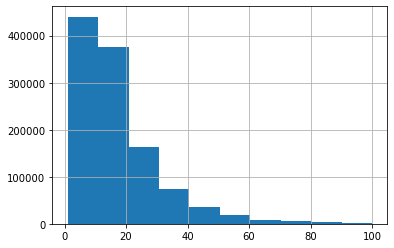

In [34]:
jan_data.duration.hist()

In [35]:
preds = lr.predict(vectorized_data)

In [36]:
preds[:3]

array([25.74633379, 25.74633379, 14.93812625])

In [37]:
jan_data.duration[:3]

0    17.000000
1    17.000000
3     8.283333
Name: duration, dtype: float64

In [38]:
mean_squared_error(jan_data.duration, preds, squared=False)

12.547089212379618